In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from sklearn.preprocessing import LabelEncoder

import torch
import torch.nn.functional as F
from torch.utils.tensorboard import SummaryWriter

from torch_geometric import seed_everything
from torch_geometric.data import Data, Dataset
from torch_geometric.loader import DataLoader
from torch_geometric.transforms import RandomLinkSplit

%config InlineBackend.figure_format='retina'

# Datasets

In [2]:
class PlainData(Data):
    """
    Custom Data class for use in PyG. Basically the same as the original Data class from PyG, but
    overrides the __inc__ method because otherwise the DataLoader was incrementing indices unnecessarily.
    Now it functions more like the original DataLoader from PyTorch itself.
    See here for more information: https://pytorch-geometric.readthedocs.io/en/latest/notes/batching.html
    """
    def __inc__(self, key, value, *args, **kwargs):
        return 0

class MyDataset(Dataset):
    """
    Dataset object containing supervision/evaluation edges. This will be used by the DataLoader to load
    batches of edges to calculate loss or evaluation metrics on. Here, get(idx) will return ALL outgoing edges of the graph
    corresponding to user "idx". This is because when calculating metrics such as recall@k, we need all of the
    user's positive edges in the same batch.
    """
    def __init__(self, root, edge_index, transform=None, pre_transform=None):
        self.edge_index = edge_index
        self.unique_idxs = torch.unique(edge_index[0,:]).tolist()
        self.num_nodes = len(self.unique_idxs)
        super().__init__(root, transform, pre_transform)

    def len(self):
        return self.num_nodes

    def get(self, idx): # returns all outgoing edges associated with playlist idx
        edge_index = self.edge_index[:, self.edge_index[0,:] == idx]
        return PlainData(edge_index=edge_index)

In [4]:
class MovieLens:
    def __init__(self):
        # df = load_pandas_df('100k', ('UserId', 'ItemId', 'Rating'))
        df = pd.read_table('ml-100k/u.data', header=None, usecols=[0, 1, 2])
        df.columns = ('UserId', 'ItemId', 'Rating')
        df = df[df['Rating'] >= 4]
        encoder = LabelEncoder()
        df['UserId'] = encoder.fit_transform(df['UserId'])
        df['ItemId'] = encoder.fit_transform(df['ItemId'])
        df['ItemId'] += df['UserId'].max() + 1
        self.num_users = df['UserId'].nunique()
        self.df = df
        self._build_graph()
        self._train_test_split()

    def _build_edge_index(self):
        users = torch.tensor(self.df['UserId'].values, dtype=torch.long)
        items = torch.tensor(self.df['ItemId'].values, dtype=torch.long)
        source = torch.cat([users, items]).reshape(1, -1)
        target = torch.cat([items, users]).reshape(1, -1)
        edges = torch.cat([source, target], dim=0)
        return edges

    def _build_graph(self):
        edges = self._build_edge_index()
        self.num_nodes = len(edges.unique())
        self.edges = edges
        graph = Data(edge_index=edges, num_nodes=self.num_nodes)
        self.graph = graph

    def _train_test_split(self, val_ratio=0.15, test_ratio=0.15):
        splitter = RandomLinkSplit(is_undirected=True, add_negative_train_samples=False,
                                   neg_sampling_ratio=0, num_val=val_ratio, num_test=test_ratio)
        train_split, val_split, test_split = splitter(self.graph)
        # Confirm that every node appears in every set above
        assert train_split.num_nodes == val_split.num_nodes and train_split.num_nodes == test_split.num_nodes

        self.train_split = train_split
        self.val_split = val_split
        self.test_split = test_split

    def get_train(self):
        train_ev = MyDataset('movielens', edge_index=self.train_split.edge_label_index)
        train_mp = Data(edge_index=self.train_split.edge_index)
        return train_ev, train_mp

    def get_val(self):
        val_ev = MyDataset('movielens', edge_index=self.val_split.edge_label_index)
        val_mp = Data(edge_index=self.val_split.edge_index)
        return val_ev, val_mp

    def get_test(self):
        test_ev = MyDataset('movielens', edge_index=self.test_split.edge_label_index)
        test_mp = Data(edge_index=self.test_split.edge_index)
        return test_ev, test_mp

In [ ]:
mov = MovieLens()

train_ev, train_mp = mov.get_train()
val_ev, val_mp = mov.get_val()
test_ev, test_mp = mov.get_test()

In [3]:
def recall_at_k(pred_items: np.array, true_items: np.array):
    assert pred_items.shape[0] == true_items.shape[0]
    recall_list = []
    for i_pred, i_true in zip(pred_items, true_items):
        try:
            hits = len(np.intersect1d(i_pred, i_true))
            recall = hits / len(i_true)
            recall_list.append(recall)
        except ZeroDivisionError:
            print(len(recall_list), i_true)
    return np.mean(recall_list)

def precision_at_k(pred_items: np.array, true_items: np.array):
    assert pred_items.shape[0] == true_items.shape[0]
    precision_list = []
    for i_pred, i_true in zip(pred_items, true_items):
        try:
            hits = len(np.intersect1d(i_pred, i_true))
            prec = hits / len(i_pred)
            precision_list.append(prec)
        except ZeroDivisionError:
            print(len(precision_list), i_true)
    return np.mean(precision_list)

# LightGCN

In [ ]:
from torch_geometric.nn import LightGCN

class CustomLightGCN(LightGCN):
    def reset_parameters(self):
        torch.nn.init.xavier_uniform_(self.embedding.weight, gain=1)
        for conv in self.convs:
            conv.reset_parameters()

In [ ]:
class Trainer:
    def __init__(self, model, optimizer, train_ev, val_ev, batch_size=256):
        self.model = model
        self.opt = optimizer
        self.train_loader = DataLoader(train_ev, batch_size=batch_size, shuffle=True)
        self.val_loader = DataLoader(val_ev, batch_size=batch_size, shuffle=False)
        self.batch_size = batch_size

        self.device = 'cpu'
        if torch.cuda.is_available():
            self.device = torch.cuda.current_device()
            self.model = self.model.to(self.device)

        self.global_train_step = 0
        self.global_val_step = 0
        self.writer = SummaryWriter("./logs")

        # сохраняем состояние оптимизатора и модели
        # self.cache = self.cache_states()

    @staticmethod
    def sample_negative_edges(batch, data_mp, num_users, num_nodes):
        negs = []
        for i in batch.edge_index[0, :]:  # looping over users
            assert i < num_users     # just ensuring that i is a user
            rand_item = torch.randint(num_users, num_nodes, (1,))  # randomly sample an item
            negs.append(rand_item.item())
        edge_index_negs = torch.row_stack([batch.edge_index[0, :], torch.LongTensor(negs)])
        return Data(edge_index=edge_index_negs, y=torch.LongTensor([0] * len(negs)))


    def train(self, data_mp, k, num_users, num_nodes):
        model = self.model
        opt = self.opt
        items = torch.tensor(np.arange(num_users, num_nodes))
        recall_all = []

        model.train()
        for batch in self.train_loader:
            del batch.batch; del batch.ptr # delete unwanted attributes

            opt.zero_grad()
            negs = self.sample_negative_edges(batch, data_mp, num_users, num_nodes)  # sample negative edges
            data_mp, batch, negs = data_mp.to(self.device), batch.to(self.device), negs.to(self.device)

            pos_scores = model.forward(data_mp['edge_index'], batch['edge_index'])
            neg_scores = model.forward(data_mp['edge_index'], negs['edge_index'])

            batch_index = batch['edge_index']
            users = batch_index[0].unique()
            recoms = model.recommend(data_mp['edge_index'], users, items, k=k)

            recall_batch = []
            for u, rec in zip(users, recoms):
                true_items = batch_index[1, batch_index[0] == u].cpu()
                hits = len(np.intersect1d(rec.cpu(), true_items))
                recall = hits / len(true_items)
                recall_batch.append(recall)
                recall_all.append(recall)

            # loss = pos_scores.shape[0] * model.recommendation_loss(pos_scores, neg_scores)
            loss = torch.mean(torch.nn.functional.softplus(neg_scores - pos_scores))
            loss.backward()
            # for p in list(filter(lambda p: p.grad is not None, model.parameters())):
            #     print(f'Gradient norm on this layer = {p.grad.data.norm(2).item()}')  # Посмотрим на норму градиентов
            opt.step()

            self.writer.add_scalar("Recall/train", np.mean(recall_batch), global_step=self.global_train_step)
            self.writer.add_scalar("Loss/train", loss.item(), global_step=self.global_train_step)
            self.global_train_step += 1

        print(f'Train avg recall = {np.mean(recall_all).round(4)}')
        print(f'Current loss = {loss.item()}')
        return loss.item()


    def test(self, data_mp, k, num_users, num_nodes, train_split=None):
        model = self.model
        items = torch.LongTensor(np.arange(num_users, num_nodes))

        model.eval()
        with torch.no_grad():
            data_mp = data_mp.to(self.device)

            recall_all = []
            for batch in self.val_loader:
                del batch.batch; del batch.ptr # delete unwanted attributes
                batch = batch['edge_index']
                batch = batch.to(self.device)
                users = batch[0].unique_consecutive()
                recoms = model.recommend(data_mp['edge_index'], users, items, k=k)

                # --- FAIR BUT LONG METHOD ---
                # for user in tqdm(users):
                    # seen_items = set(train_split[1, train_split[0] == user].tolist())
                    # unseen_items = torch.LongTensor(list(items.difference(seen_items)))
                    # rec = model.recommend(data_mp['edge_index'], user, torch.tensor(list(items)), k=k)
                    # true_items = batch[1, batch[0] == user].cpu()

                recall_batch = []
                for u, rec in zip(users, recoms):
                    true_items = batch[1, batch[0] == u].cpu()
                    hits = len(np.intersect1d(rec.cpu(), true_items))
                    recall = hits / len(true_items)
                    recall_batch.append(recall)
                    recall_all.append(recall)

                self.writer.add_scalar("Recall/valid", np.mean(recall_batch), global_step=self.global_val_step)
                self.global_val_step += 1

        print(f'Valid avg recall = {np.mean(recall_all).round(4)}')

In [2]:
%load_ext tensorboard

In [3]:
%tensorboard --logdir logs/

Launching TensorBoard...

# twin-LGCN-U/E

In [4]:
pd.options.mode.chained_assignment = None

In [5]:
from torch_geometric.nn import MessagePassing
from torch_geometric import utils
from torch_geometric.utils import degree
from sklearn.metrics.pairwise import cosine_similarity

In [6]:
class SimpleProp(MessagePassing):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)

    def forward(self, x, edge_index, size):
        return self.propagate(edge_index, x=x, size=size)

    def message(self, x_j):
        return x_j

In [7]:
class LGCN_U(torch.nn.Module):
    def __init__(self, n_users, emb_dim, alphas=(1, 1), normalize=False, **kwargs):
        super().__init__()
        self.m = n_users
        self.normalize = normalize
        self.alphas = alphas
        self.U_0 = torch.nn.Embedding(self.m, emb_dim)
        self.layer_1 = SimpleProp(**kwargs)  # E_1 = R.T @ U
        self.layer_2 = SimpleProp(**kwargs)  # U_2 = R @ E_1
        self.layer_3 = SimpleProp(**kwargs)  # E_3 = R @ U_2

    def get_embeddings(self, edge_index, n=None):
        """
        Propagate messages through the graph and return fused final embeddings of users ans items: U, E.

        Parameters:
        ----------
        edge_index : Tensor
            Edge tensor specifying the connectivity of the graph
        n : int (optional)
            Number of items

        Returns:
        -------
            U : Tensor
                User embeddings of shape (m, emb_dim)
            E : Tensor
                Item embeddings of shape (n, emb_dim)
        """
        if n is None:
            n = edge_index[1].max().item() + 1
        m = self.m

        if self.normalize:
            inv_sqrt_user_degrees = degree(edge_index[0]).pow(-0.5)
            inv_sqrt_item_degrees = degree(edge_index[1]).pow(-0.5)
            # inv_norm = inv_sqrt_user_degrees * inv_sqrt_item_degrees
        else:
            inv_sqrt_item_degrees = torch.Tensor(1)
            inv_sqrt_user_degrees = torch.Tensor(1)

        E_1 = self.layer_1.forward(self.U_0.weight, edge_index=edge_index, size=(m, n)) * inv_sqrt_item_degrees.view(-1, 1)
        U_2 = self.layer_2.forward(E_1, edge_index[[1, 0], :], size=(n, m)) * inv_sqrt_user_degrees.view(-1, 1)
        E_3 = self.layer_3.forward(U_2, edge_index, size=(m, n)) * inv_sqrt_item_degrees.view(-1, 1)

        E = 0.5 * (E_1 + E_3)
        U = 0.5 * (self.U_0.weight + U_2)
        return U, E

    def forward(self, edge_index, edge_label_index, n_items=None):
        """
        Computes rankings for pairs of nodes using learned user embeddings.

        Parameters
        ----------
        edge_index: Tensor
            Edge tensor specifying the connectivity of the graph
        edge_label_index: Tensor, optional
            Edge tensor specifying the node pairs for which to compute rankings or probabilities
        n_items: int (optional)
            Number of items

        Returns
        -------
        scores : Tensor
            Scores of edges of shape (edge_index_label, ).
        """
        if edge_label_index is None:
            edge_label_index = edge_index

        U, E = self.get_embeddings(edge_index, n=n_items)
        src = U[edge_label_index[0]]
        dst = E[edge_label_index[1]]
        return (src * dst).sum(dim=-1)

    def recommend_top_k(self, n):
        pass

### Pipeline (sanity check)

In [246]:
pos_edges = torch.nonzero(R).T
pos_edges

tensor([[0, 0, 1, 2],
        [0, 1, 2, 0]])

In [247]:
neg_edges = utils.negative_sampling(pos_edges, num_nodes=(3, 4))
neg_edges

tensor([[0, 1, 2, 1],
        [2, 0, 2, 3]])

In [340]:
model = LGCN_U(n_users=3, emb_dim=3)
opt = torch.optim.Adam(model.parameters(), lr=3e-2)
metrics = []

0.24593006074428558


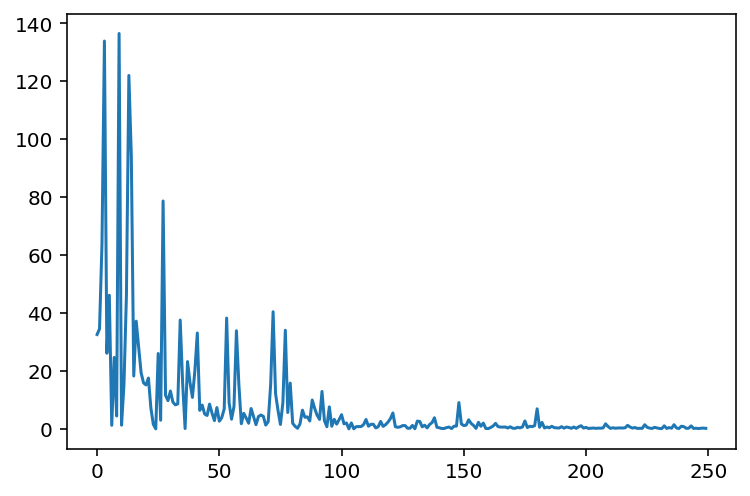

In [351]:
for i in range(10):
    opt.zero_grad()
    neg_edges = utils.negative_sampling(pos_edges, num_nodes=(3, 4))
    pos_scores = model.predict(edges_index=pos_edges, n_items=4)
    neg_scores = model.predict(edges_index=neg_edges, n_items=4)

    loss = torch.mean(F.softplus(neg_scores - pos_scores))
    # print(loss.item())
    loss.backward()
    opt.step()
    metrics.append(loss.item())
print(metrics[-1])
plt.plot(metrics)
plt.show()

In [352]:
cosine_similarity(model.forward(edge_index=pos_edges, n=4)[0].data.numpy())

array([[ 1.       , -0.7746767,  0.8162699],
       [-0.7746767,  1.       , -0.933676 ],
       [ 0.8162699, -0.933676 ,  0.9999999]], dtype=float32)

In [353]:
new_R = torch.Tensor([[1, 1, 0], [1, 1, 0], [0, 0, 1]])
new_R

tensor([[1., 1., 0.],
        [1., 1., 0.],
        [0., 0., 1.]])

In [354]:
new_edges = torch.nonzero(new_R).T
new_edges[1] += 4
new_edges

tensor([[0, 0, 1, 1, 2],
        [4, 5, 4, 5, 6]])

In [355]:
cosine_similarity(model.forward(torch.cat([pos_edges, new_edges], dim=1), 7)[0].detach().numpy())

array([[ 0.9999999 ,  0.09845882,  0.4470191 ],
       [ 0.09845882,  0.9999999 , -0.77198714],
       [ 0.4470191 , -0.77198714,  0.9999999 ]], dtype=float32)

In [356]:
_U, _E = model.forward(torch.cat([pos_edges, new_edges], dim=1), 7)

In [361]:
torch.cat([R, new_R], dim=1)

tensor([[1., 1., 0., 0., 1., 1., 0.],
        [0., 0., 1., 0., 1., 1., 0.],
        [1., 0., 0., 0., 0., 0., 1.]])

In [359]:
_U @ _E.T

tensor([[ 7.1969,  5.7982,  0.3556,  0.0000,  6.1539,  6.1539,  1.3987],
        [-1.1491,  0.3556,  2.2500,  0.0000,  2.6057,  2.6057, -1.5047],
        [ 3.0872,  1.3987, -1.5047,  0.0000, -0.1060, -0.1060,  1.6885]],
       grad_fn=<MmBackward0>)

### MovieLens

In [8]:
from sklearn.model_selection import train_test_split

In [9]:
class MovieLens:
    def __init__(self, path, nrows=None):
        df = pd.read_table(path, header=None, nrows=nrows)
        df.columns = ['user_id', 'item_id', 'rating', 'timestamp']
        df['timestamp'] = pd.to_datetime(df['timestamp'], unit='s')
        df['user_id'] -= 1
        df['item_id'] -= 1
        df = df[df['rating'] >= 4]
        df['rating'] = 1
        self.df = df

    def train_test_split(self, test_ratio=0.25, observed_ratio=0.5):
        df = self.df
        all_users = self.df['user_id'].unique()
        test_size = int(len(all_users) * test_ratio)

        # Формируем выборку пользователей для теста
        test_users = np.random.choice(a=all_users, size=test_size, replace=False)
        df_train = df[~df['user_id'].isin(test_users)]
        df_test = df[df['user_id'].isin(test_users)]
        df_test = df_test[df_test['item_id'].isin(df_train['item_id'].unique())]

        # Энкодим айдишники айтемов
        encoder = LabelEncoder()
        df_train['user_id'] = encoder.fit_transform(df_train['user_id'])
        df_train['item_id'] = encoder.fit_transform(df_train['item_id'])
        df_test['item_id'] = encoder.transform(df_test['item_id'])

        # Делим интеракции новых пользователей на виденные и будущие
        test_observed, test_future = train_test_split(df_test, test_size=1-observed_ratio, random_state=42)
        test_future = test_future[test_future['user_id'].isin(test_observed['user_id'].unique())]
        test_observed['user_id'] = encoder.fit_transform(test_observed['user_id'])
        test_future['user_id'] = encoder.transform(test_future['user_id'])

        self.train = df_train
        self.test_observed = test_observed
        self.test_future = test_future
        self.n_items = df_train['item_id'].nunique()

In [10]:
np.random.seed(42)
mov = MovieLens('ml-100k/u.data')
mov.df.shape

(55375, 4)

In [769]:
mov.train_test_split(test_ratio=0.3, observed_ratio=0.1)

In [770]:
mov.train.nunique()

user_id        660
item_id       1388
rating           1
timestamp    22374
dtype: int64

In [771]:
mov.test_observed.nunique()

user_id       257
item_id       599
rating          1
timestamp    1566
dtype: int64

In [772]:
mov.test_future.nunique()

user_id       257
item_id      1120
rating          1
timestamp    9012
dtype: int64

In [973]:
pos_edges = torch.LongTensor(mov.train[['item_id', 'user_id']].values.T)
pos_edges

tensor([[ 464,  455,  219,  ..., 1044,  417,  528],
        [ 214,  186,  151,  ...,  347,  567,  479]])

In [970]:
test_observed_edges = torch.LongTensor(mov.test_observed[['item_id', 'user_id']].values.T)
test_observed_edges[1] += mov.train['user_id'].nunique()
test_observed_edges.min(dim=1).values, test_observed_edges.max(dim=1).values

(tensor([  0, 660]), tensor([1364,  916]))

In [787]:
test_future_edges = torch.LongTensor(mov.test_future[['item_id', 'user_id']].values.T)
test_future_edges[1] += mov.train['user_id'].nunique()

In [788]:
test_observed_edges.shape, test_future_edges.shape

(torch.Size([2, 1691]), torch.Size([2, 14863]))

In [775]:
len(pos_edges[0].unique()), len(pos_edges[1].unique())

(1388, 660)

In [1481]:
torch.randperm(5)

tensor([1, 2, 3, 4, 0])

In [1510]:
def train_val_split(pos_edges, val_ratio):
    """
    Split edges so that all users presence both in train in validation splits.
    Cut specified ratio of edges for each user, providing balanced partitioning.

    Parameters:
    ----------
    pos_edges: LongTensor
        All edges the directed (user, item) graph; the shape is (2, E)
    val_ratio: float
        Share of validation edges in all positive edges of given graph

    Returns:
    -------
    train_edges: LongTensor
    val_edges: LongTensor
    """
    val_edges = []
    train_edges = []
    for user in pos_edges[0].unique():
        edges = pos_edges[:, pos_edges[0] == user]
        n_items = edges.shape[1]
        # edges = edges[:, torch.randperm(n_items)]
        if n_items == 1:
            thr = 1
        else:
            thr = int(n_items * (1-val_ratio))
        train_edges.append(edges[:, :thr])
        val_edges.append(edges[:, thr:])

    val_edges = torch.cat(val_edges, dim=1)
    train_edges = torch.cat(train_edges, dim=1)
    return train_edges, val_edges

train_edges, val_edges = train_val_split(pos_edges, 0.2)
val_edges.shape[1] / pos_edges.shape[1]

0.21181803970611224

In [1525]:
model = LGCN_U(n_users=mov.train['item_id'].nunique(), emb_dim=64, normalize=True)
opt = torch.optim.Adam(model.parameters(), lr=3e-4)
metrics = []
acc_list = []

In [1534]:
for i in tqdm(range(200)):
    opt.zero_grad()
    neg_edges = utils.negative_sampling(train_edges, num_neg_samples=train_edges.shape[1],
                                        num_nodes=(model.m, mov.train['user_id'].nunique()))
    neg_val_edges = utils.negative_sampling(pos_edges, num_neg_samples=val_edges.shape[1],
                                            num_nodes=(model.m, mov.train['user_id'].nunique()))

    train_scores = model.forward(edge_index=train_edges, edge_label_index=train_edges, n_items=mov.train['user_id'].nunique())
    neg_scores = model.forward(edge_index=train_edges, edge_label_index=neg_edges, n_items=mov.train['user_id'].nunique())

    val_scores = model.forward(edge_index=train_edges, edge_label_index=val_edges, n_items=mov.train['user_id'].nunique())
    neg_val_scores = model.forward(edge_index=train_edges, edge_label_index=neg_val_edges, n_items=mov.train['user_id'].nunique())

    #  ==== VALIDATION ====
    # _toe = test_observed_edges.clone()
    # _toe[1] -= mov.train['user_id'].nunique()
    # neg_val_edges = utils.negative_sampling(_toe, num_nodes=(model.m, mov.test_observed['user_id'].nunique()))
    # neg_val_edges[1] += mov.train['user_id'].nunique()
    # val_scores = model.forward(edge_index=torch.cat([pos_edges, test_observed_edges], dim=1),
    #                            edge_label_index=test_observed_edges, n_items=test_observed_edges[1].max().item() + 1)
    # neg_val_scores = model.forward(edge_index=torch.cat([pos_edges, test_observed_edges], dim=1),
    #                                edge_label_index=neg_val_edges, n_items=test_observed_edges[1].max().item() + 1)

    # ==== TEST ====
    _tfe = test_future_edges.clone()
    _tfe[1] -= mov.train['user_id'].nunique()
    neg_test_edges = utils.negative_sampling(_tfe, num_nodes=(model.m, mov.test_observed['user_id'].nunique()))
    neg_test_edges[1] += mov.train['user_id'].nunique()
    test_scores = model.forward(edge_index=torch.cat([pos_edges, test_observed_edges], dim=1),
                                edge_label_index=test_future_edges, n_items=test_observed_edges[1].max().item() + 1)
    neg_test_scores = model.forward(edge_index=torch.cat([pos_edges, test_observed_edges], dim=1),
                                   edge_label_index=neg_test_edges, n_items=test_observed_edges[1].max().item() + 1)

    train_loss = torch.mean(F.softplus(neg_scores - train_scores))
    val_loss = torch.mean(F.softplus(neg_val_scores - val_scores))
    test_loss = torch.mean(F.softplus(neg_test_scores - test_scores))

    train_acc = (train_scores > neg_scores).float().mean()
    val_acc = (val_scores > neg_val_scores).float().mean()
    test_acc = (test_scores > neg_test_scores).float().mean()

    if i % 10 == 0:
        print(f'Train loss = {train_loss}, val_loss = {val_loss}, test_loss = {test_loss}, test_acc={test_acc}')
    train_loss.backward()
    opt.step()
    metrics.append([train_loss.item(), val_loss.item(), test_loss.item()])
    acc_list.append([train_acc.item(), val_acc.item(), test_acc.item()])

  0%|          | 0/200 [00:00<?, ?it/s]

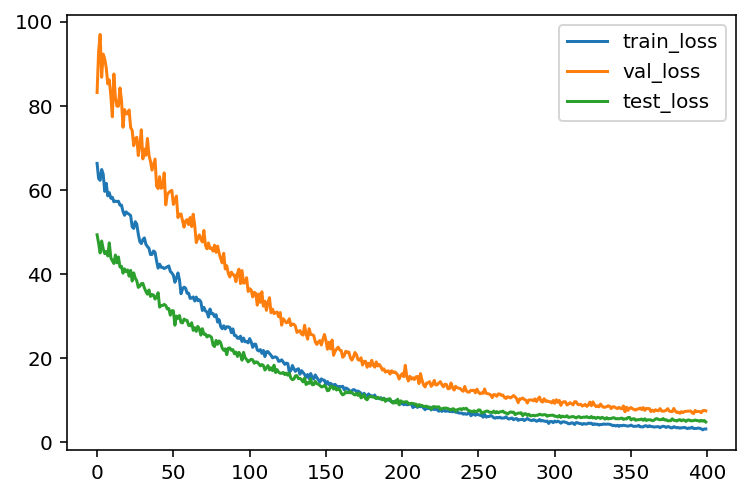

In [1535]:
plt.plot(metrics[:], label=['train_loss', 'val_loss', 'test_loss'])
plt.legend()
plt.show()

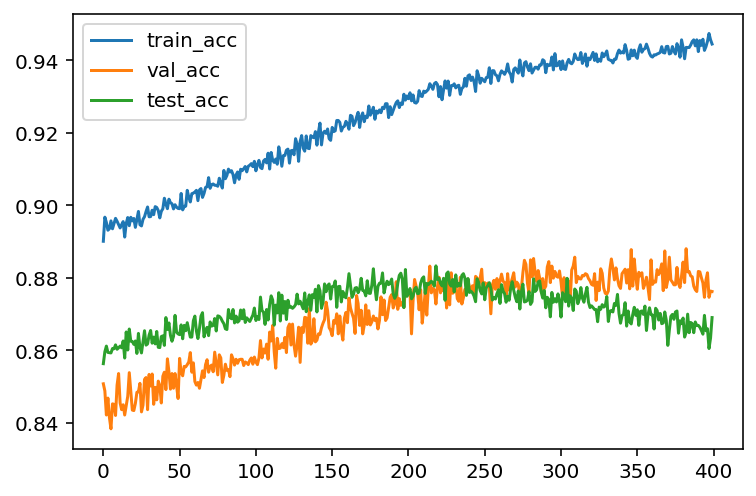

In [1536]:
plt.plot(acc_list, label=['train_acc', 'val_acc', 'test_acc'])
plt.legend()
plt.show()

In [1530]:
with torch.no_grad():
    _U, _E = model.get_embeddings(torch.cat([pos_edges, test_observed_edges], dim=1))
    # _U, _E = model.get_embeddings(pos_edges)
_U.shape, _E.shape

(torch.Size([1388, 64]), torch.Size([917, 64]))

In [1537]:
new_scores = _E @ _U.T
new_scores[test_observed_edges[1], test_observed_edges[0]] = -1e5  # exclude seen items
new_scores = new_scores[mov.train['user_id'].nunique():]
new_scores.shape

torch.Size([257, 1388])

In [1538]:
recs = new_scores.topk(20, dim=1).indices.numpy()
recs

array([[310, 283, 255, ..., 291, 219,   6],
       [ 97, 131, 473, ...,  88, 169, 208],
       [ 49,  97, 173, ..., 419, 473,  11],
       ...,
       [ 49,  97, 171, ..., 213, 208,  95],
       [299, 266, 310, ..., 268,   0, 295],
       [297, 285, 324, ...,  14, 727, 115]])

In [1539]:
y_true = mov.test_future.groupby('user_id')['item_id'].unique().values
# y_true = mov.train.groupby('user_id')['item_id'].unique().values
print('===== LGCN-E =====')
print(f'Precsion = {precision_at_k(recs, y_true).round(5)}')
print(f'Recall = {recall_at_k(recs, y_true).round(5)}')

===== LGCN-E =====
Precsion = 0.41323
Recall = 0.19772


In [1143]:
mov.test_observed.groupby('user_id')['item_id'].count().median()

4.0

In [317]:
mov.test_future.groupby('user_id')['item_id'].count().median()

40.0

In [319]:
20 / mov.train['user_id'].nunique()

0.030303030303030304